###Uranium Demand

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [6]:
dataset_path = 'owid-energy-data.csv'

In [7]:
df = pd.read_csv(dataset_path)

In [8]:
años = [int(a) for a in df['year'].unique()]
años.sort()
print(años)


[1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [9]:
columnas = list(df.columns)
for col in columnas:
    print(col)

country
year
iso_code
population
gdp
biofuel_cons_change_pct
biofuel_cons_change_twh
biofuel_cons_per_capita
biofuel_consumption
biofuel_elec_per_capita
biofuel_electricity
biofuel_share_elec
biofuel_share_energy
carbon_intensity_elec
coal_cons_change_pct
coal_cons_change_twh
coal_cons_per_capita
coal_consumption
coal_elec_per_capita
coal_electricity
coal_prod_change_pct
coal_prod_change_twh
coal_prod_per_capita
coal_production
coal_share_elec
coal_share_energy
electricity_demand
electricity_demand_per_capita
electricity_generation
electricity_share_energy
energy_cons_change_pct
energy_cons_change_twh
energy_per_capita
energy_per_gdp
fossil_cons_change_pct
fossil_cons_change_twh
fossil_elec_per_capita
fossil_electricity
fossil_energy_per_capita
fossil_fuel_consumption
fossil_share_elec
fossil_share_energy
gas_cons_change_pct
gas_cons_change_twh
gas_consumption
gas_elec_per_capita
gas_electricity
gas_energy_per_capita
gas_prod_change_pct
gas_prod_change_twh
gas_prod_per_capita
gas_produ

In [10]:
# Seleccionamos las columnas fijas
columnas_base = ['country', 'year', 'iso_code', 'population', 'gdp']

# Encontramos todas las columnas que contienen 'nuclear' en su nombre
columnas_nuclear = [col for col in df.columns if 'nuclear' in col]

# Unimos ambas listas
columnas_seleccionadas = columnas_base + columnas_nuclear

# Creamos el nuevo df solo con esas columnas
df_filtrado = df[columnas_seleccionadas]

# Eleiminamos aquellas en las que no exista consumo alguno
df_nuke = df_filtrado[~df_filtrado['nuclear_consumption'].isna() & (df_filtrado['nuclear_consumption'] != '')]

# Guardamos en CSV
df_nuke.to_csv('datos_nuclear.csv', index=False)


In [11]:
#Este df será el que tomemos como referencia en el estudio sobre el comsumo nuclear
df_nuclear_consumo = pd.read_csv('datos_nuclear.csv')

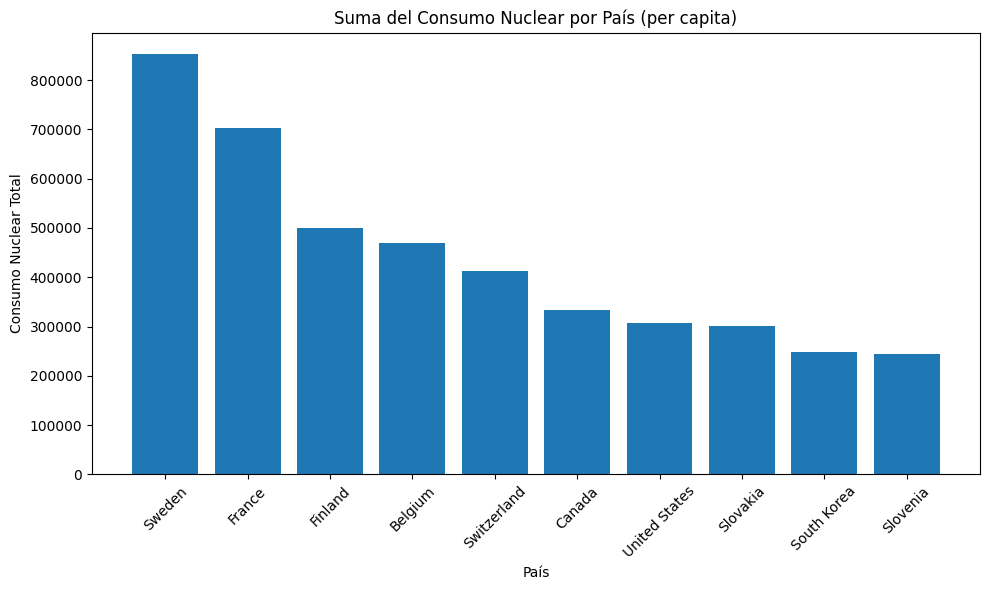

In [12]:
# Lista de nombres de regiones/agregados que no queremos visualizar ya que solo queremos paises
agrupaciones = [
    'World',
    'High-income countries',
    'OECD (EI)',
    'Europe',
    'Europe (EI)',
    'North America',
    'North America (EI)',
    'European Union (27)',
    'Asia',
    'Asia Pacific (EI)',
    'Non-OECD (EI)',
    'Upper-middle-income countries',
    'CIS (EI)'
]


# Agrupamos por país y sumamos el consumo nuclear
consumo_per_capita = df_nuclear_consumo.groupby('country')['nuclear_energy_per_capita'].sum().reset_index()

# Ordenar de mayor a menor consumo
consumo_per_capita = consumo_per_capita.sort_values(by='nuclear_energy_per_capita', ascending=False)
# Filtramos el df para excluir esas agrupaciones
solo_paises = consumo_per_capita[~consumo_per_capita['country'].isin(agrupaciones)]

top10_paises = solo_paises.head(10)
plt.figure(figsize=(10,6))
plt.bar(top10_paises['country'], top10_paises['nuclear_energy_per_capita'])
plt.xlabel('País')
plt.ylabel('Consumo Nuclear Total')
plt.title('Suma del Consumo Nuclear por País (per capita)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


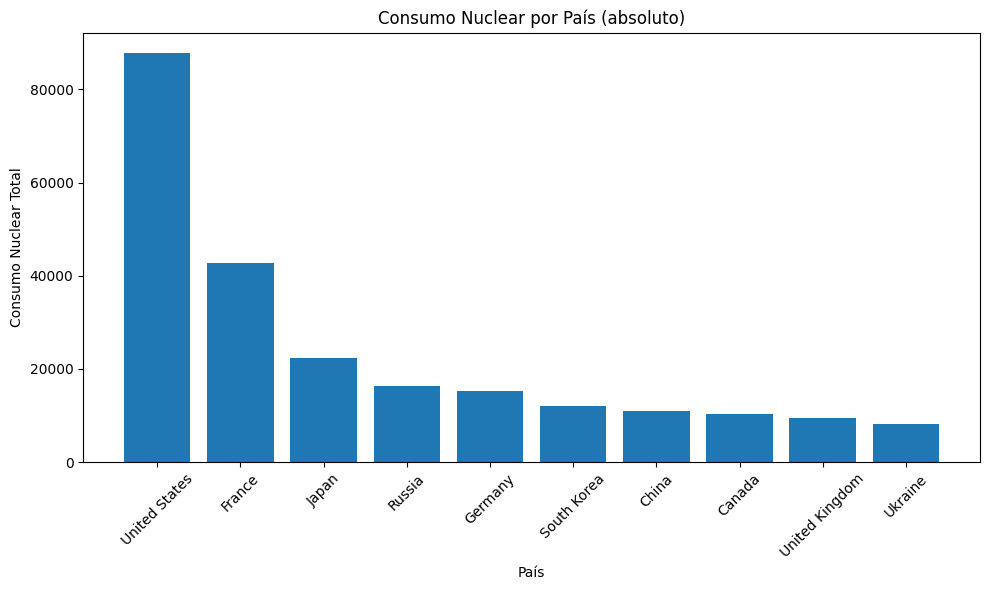

In [13]:
# Agrupamos por país y sumamos el consumo nuclear
consumo_total = df_nuclear_consumo.groupby('country')['nuclear_consumption'].sum().reset_index()
# Ordenar de mayor a menor
consumo_total = consumo_total.sort_values(by='nuclear_consumption', ascending=False)
# Excluimos agrupaciones/regiones como antes
solo_paises_ele = consumo_total[~consumo_total['country'].isin(agrupaciones)]
top10_ele = solo_paises_ele.head(10)
# Gráfico
plt.figure(figsize=(10,6))
plt.bar(top10_ele['country'], top10_ele['nuclear_consumption'])
plt.xlabel('País')
plt.ylabel('Consumo Nuclear Total')
plt.title('Consumo Nuclear por País (absoluto)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Vamos a centrarnos en el consumo total de energía nuclear


In [14]:
cor_matrix = df_nuclear_consumo.select_dtypes(include='number').corr()
cor_matrix

,year,population,gdp,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy
year,1.000000,0.047549,0.104885,-0.103889,-0.096161,0.115503,0.148816,0.120738,0.136888,-0.068967,0.194073
population,0.047549,1.000000,0.925754,-0.026272,0.263763,0.644281,-0.022553,0.650900,-0.021955,0.014787,-0.005123
gdp,0.104885,0.925754,1.000000,-0.021228,0.156707,0.893802,0.053764,0.908966,0.053530,0.037856,0.041980
nuclear_cons_change_pct,-0.103889,-0.026272,-0.021228,1.000000,0.005149,-0.044320,-0.061043,-0.044366,-0.060282,-0.058088,-0.063645
nuclear_cons_change_twh,-0.096161,0.263763,0.156707,0.005149,1.000000,0.234642,0.041516,0.217199,0.047601,0.061087,0.047761
nuclear_consumption,0.115503,0.644281,0.893802,-0.044320,0.234642,1.000000,0.223758,0.998986,0.226418,0.266002,0.258530
nuclear_elec_per_capita,0.148816,-0.022553,0.053764,-0.061043,0.041516,0.223758,1.000000,0.223141,0.998844,0.880125,0.934617
nuclear_electricity,0.120738,0.650900,0.908966,-0.044366,0.217199,0.998986,0.223141,1.000000,0.224515,0.264352,0.257467
nuclear_energy_per_capita,0.136888,-0.021955,0.053530,-0.060282,0.047601,0.226418,0.998844,0.224515,1.000000,0.879197,0.931880
nuclear_share_elec,-0.068967,0.014787,0.037856,-0.058088,0.061087,0.266002,0.880125,0.264352,0.879197,1.000000,0.970959


In [15]:
#nuclear_consumption y nuclear_electricity: 0.999 - prácticamente perfecta, indicando que el consumo nuclear se traduce directamente en generación eléctrica
#Lo que nos lleva a prescindir de el campo de nuclear electricity
#nuclear_consumption y gdp: 0.893 - correlación fuerte, sugiriendo que países con mayor PIB tienden a tener mayor consumo nuclear absoluto
#nuclear_electricity vs nuclear_elec_per_capita (0.223)
#nuclear_energy_per_capita vs población (-0.022)

In [16]:
##################################################################################################
cor_with_nuclear = df_nuclear_consumo.select_dtypes(include='number').corr()['nuclear_consumption']
cor_with_nuclear


year                         0.115503
population                   0.644281
gdp                          0.893802
nuclear_cons_change_pct     -0.044320
nuclear_cons_change_twh      0.234642
nuclear_consumption          1.000000
nuclear_elec_per_capita      0.223758
nuclear_electricity          0.998986
nuclear_energy_per_capita    0.226418
nuclear_share_elec           0.266002
nuclear_share_energy         0.258530
Name: nuclear_consumption, dtype: float64

In [17]:
cols = df.columns.tolist()
cols_final = [col for col in cols if col in ['year', 'country', 'nuclear_consumption'] or (col in cor_with_nuclear and 0.2 <= abs(cor_with_nuclear[col]) <= 0.9)]
cols_final


['country',
 'year',
 'population',
 'gdp',
 'nuclear_cons_change_twh',
 'nuclear_consumption',
 'nuclear_elec_per_capita',
 'nuclear_energy_per_capita',
 'nuclear_share_elec',
 'nuclear_share_energy']

In [18]:
df_model = df_nuclear_consumo[cols_final]
df_model

,country,year,population,gdp,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy
0,Africa,1965,321010751.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0
1,Africa,1966,329249583.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
2,Africa,1967,337848285.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
3,Africa,1968,346798203.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
4,Africa,1969,356029849.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
7854,Zimbabwe,2020,15526837.0,2.317871e+10,0.0,0.0,0.0,0.0,0.0,NaN
7855,Zimbabwe,2021,15797165.0,2.514009e+10,0.0,0.0,0.0,0.0,0.0,NaN
7856,Zimbabwe,2022,16069010.0,2.590159e+10,0.0,0.0,0.0,0.0,0.0,NaN
7857,Zimbabwe,2023,16340778.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN


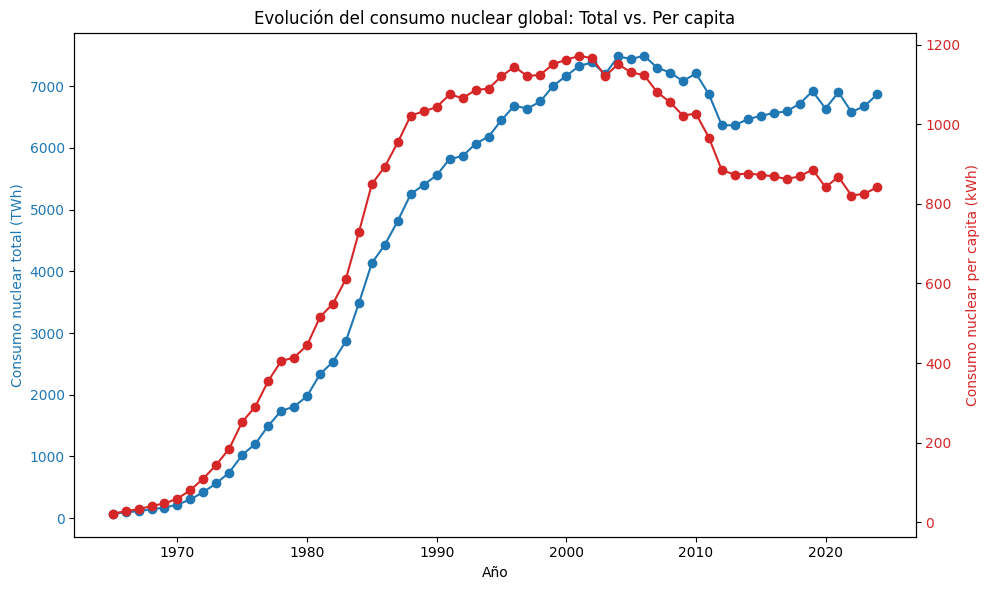

In [19]:
#VISUALIZEMOS LA EVOLUCIÓN DE CONSUMO NUCLEAR GLOBAL (total vs per capita) AÑO TRAS AÑO
df_global = df_nuclear_consumo[df_nuclear_consumo['country'] == 'World']

fig, ax1 = plt.subplots(figsize=(10,6))

# Primer eje: Consumo nuclear total en TWh
color = 'tab:blue'
ax1.set_xlabel('Año')
ax1.set_ylabel('Consumo nuclear total (TWh)', color=color)
ax1.plot(df_global['year'], df_global['nuclear_consumption'], marker='o', color=color, label='Total')
ax1.tick_params(axis='y', labelcolor=color)

# Segundo eje: Consumo nuclear per capita en kWh
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Consumo nuclear per capita (kWh)', color=color)
ax2.plot(df_global['year'], df_global['nuclear_energy_per_capita'], marker='o', color=color, label='Per capita')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolución del consumo nuclear global: Total vs. Per capita')
plt.tight_layout()
plt.show()

In [20]:
df_nuclear = df_nuclear_consumo[df_nuclear_consumo['country'] == 'World'][['year', 'nuclear_consumption']].dropna()
serie = df_nuclear['nuclear_consumption'].values

# Generar variables de rezago
def crear_lags(serie, n_lags):
    X, y = [], []
    for i in range(n_lags, len(serie)):
        X.append(serie[i - n_lags:i])
        y.append(serie[i])
    return np.array(X), np.array(y)

n_lags = 3
X, y = crear_lags(serie, n_lags)

# Dividir en conjunto de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Entrenar el modelo XGBoost
modelo = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)

# Evaluación

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 169.63457218173016


In [21]:
##########ARIMA Model

DATOS DE CONSUMO GLOBAL DE ENERGÍA NUCLEAR

Período: 1965 - 2024
Número de observaciones: 60

Últimas 5 observaciones:
    year  nuclear_consumption
55  2020             6639.518
56  2021             6903.327
57  2022             6583.331
58  2023             6677.130
59  2024             6871.835

TEST AUGMENTED DICKEY-FULLER: NUCLEAR CONSUMPTION (Original)

Estadístico de prueba: -1.987095
P-value: 0.292260
Número de lags usados: 1
Número de observaciones: 58
AIC (Akaike Information Criterion): 642.06

Valores críticos:
  1%: -3.548
  5%: -2.913
  10%: -2.594

──────────────────────────────────────────────────────────────────────
❌ RESULTADO: La serie NO es estacionaria
   (p-value 0.292260 >= 0.05)
   → Necesita diferenciación (d ≥ 1)
──────────────────────────────────────────────────────────────────────

APLICANDO DIFERENCIACIÓN (d=1)

TEST AUGMENTED DICKEY-FULLER: NUCLEAR CONSUMPTION (d=1)

Estadístico de prueba: -2.114480
P-value: 0.238732
Número de lags usados: 2
Número de obser

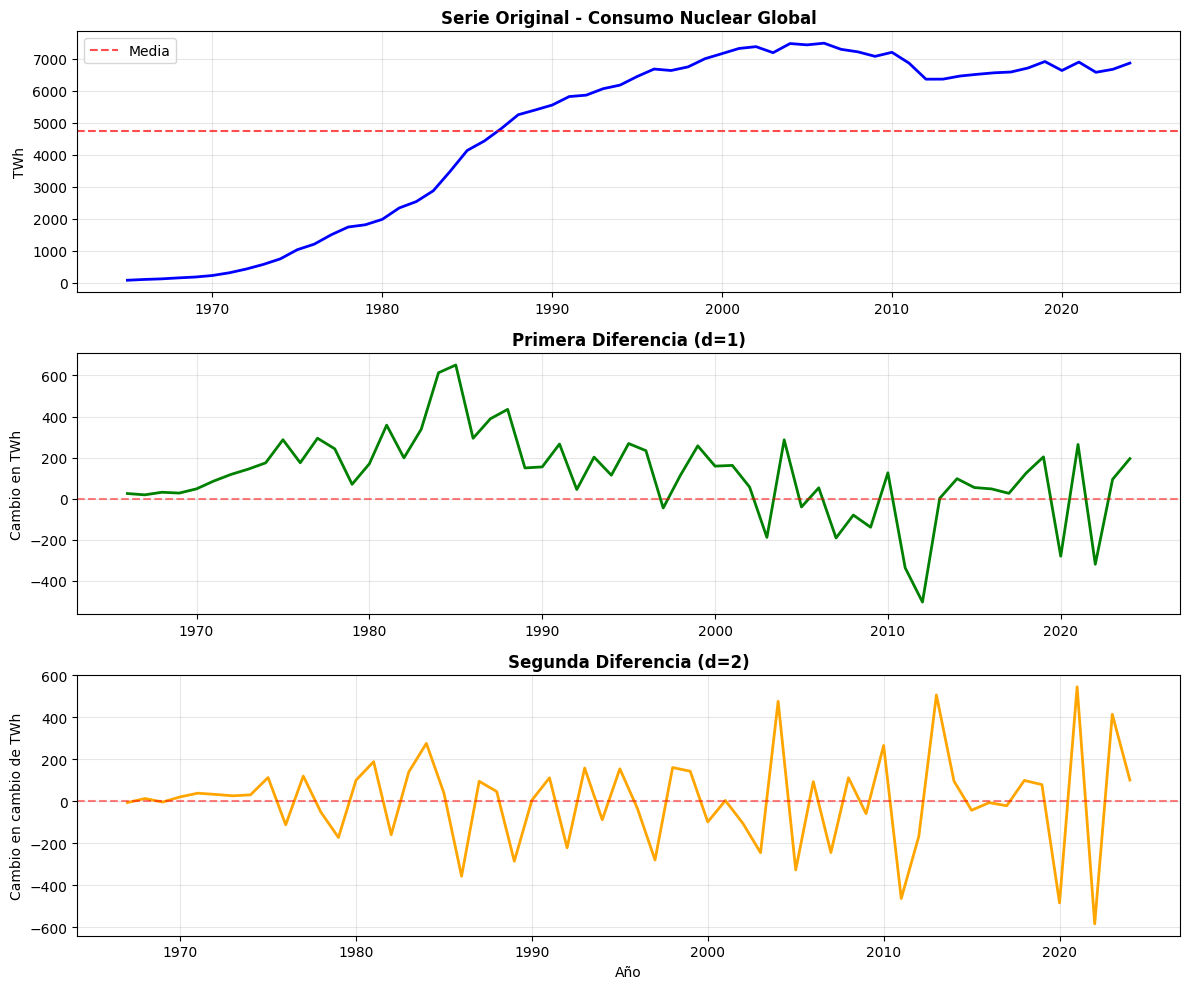


RESUMEN Y RECOMENDACIÓN PARA MODELO ARIMAX

✅ Recomendación: d = 2 (segunda diferencia)

Próximo paso: Usar d=2 en tu modelo ARIMAX(p, 2, q)


In [22]:
# Filtrar solo datos de consumo global de energía nuclear
df_nuclear = df_nuclear_consumo[df_nuclear_consumo['country'] == 'World'].copy()
df_nuclear = df_nuclear[['year', 'nuclear_consumption']].dropna()
df_nuclear = df_nuclear.sort_values('year').reset_index(drop=True)

print("=" * 70)
print("DATOS DE CONSUMO GLOBAL DE ENERGÍA NUCLEAR")
print("=" * 70)
print(f"\nPeríodo: {df_nuclear['year'].min()} - {df_nuclear['year'].max()}")
print(f"Número de observaciones: {len(df_nuclear)}")
print("\nÚltimas 5 observaciones:")
print(df_nuclear.tail())

# Extraer la serie temporal
serie_nuclear = df_nuclear['nuclear_consumption'].values

# ============================================================================
# 2. FUNCIÓN PARA APLICAR EL TEST ADF
# ============================================================================
def aplicar_adf_test(serie, nombre_serie="Serie"):
    """
    Aplica el test Augmented Dickey-Fuller a una serie temporal
    
    Parámetros:
        serie: array con los datos de la serie
        nombre_serie: nombre descriptivo de la serie
    
    Retorna:
        dict con resultados del test
    """
    print(f"\n{'=' * 70}")
    print(f"TEST AUGMENTED DICKEY-FULLER: {nombre_serie}")
    print(f"{'=' * 70}")
    
    # Realizar el test ADF
    resultado_adf = adfuller(serie, autolag='AIC')
    
    # Extraer resultados
    estadistico = resultado_adf[0]
    p_value = resultado_adf[1]
    num_lags = resultado_adf[2]
    num_obs = resultado_adf[3]
    valores_criticos = resultado_adf[4]
    ic_mejor = resultado_adf[5]
    
    # Mostrar resultados
    print(f"\nEstadístico de prueba: {estadistico:.6f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Número de lags usados: {num_lags}")
    print(f"Número de observaciones: {num_obs}")
    print(f"AIC (Akaike Information Criterion): {ic_mejor:.2f}")
    
    print(f"\nValores críticos:")
    for clave, valor in valores_criticos.items():
        print(f"  {clave}: {valor:.3f}")
    
    # Interpretación
    print(f"\n{'─' * 70}")
    if p_value < 0.05:
        print("✅ RESULTADO: La serie ES ESTACIONARIA")
        print(f"   (p-value {p_value:.6f} < 0.05)")
        print("   → No necesita diferenciación, parámetro d=0")
    else:
        print("❌ RESULTADO: La serie NO es estacionaria")
        print(f"   (p-value {p_value:.6f} >= 0.05)")
        print("   → Necesita diferenciación (d ≥ 1)")
    print(f"{'─' * 70}")
    
    # Retornar como diccionario
    return {
        'estadistico': estadistico,
        'p_value': p_value,
        'es_estacionaria': p_value < 0.05,
        'lags': num_lags
    }

# ============================================================================
# 3. APLICAR EL TEST A LA SERIE ORIGINAL
# ============================================================================
resultado_original = aplicar_adf_test(serie_nuclear, "NUCLEAR CONSUMPTION (Original)")

# ============================================================================
# 4. APLICAR EL TEST A LA SERIE DIFERENCIADA (si no es estacionaria)
# ============================================================================
if not resultado_original['es_estacionaria']:
    print("\n" + "=" * 70)
    print("APLICANDO DIFERENCIACIÓN (d=1)")
    print("=" * 70)
    
    # Primera diferencia
    serie_diferenciada = np.diff(serie_nuclear, n=1)
    resultado_diferenciada = aplicar_adf_test(serie_diferenciada, "NUCLEAR CONSUMPTION (d=1)")
    
    # Si aún no es estacionaria, probar segunda diferencia
    if not resultado_diferenciada['es_estacionaria']:
        print("\n" + "=" * 70)
        print("APLICANDO SEGUNDA DIFERENCIACIÓN (d=2)")
        print("=" * 70)
        
        serie_diferenciada_2 = np.diff(serie_nuclear, n=2)
        resultado_diferenciada_2 = aplicar_adf_test(serie_diferenciada_2, "NUCLEAR CONSUMPTION (d=2)")

# ============================================================================
# 5. VISUALIZACIÓN COMPARATIVA
# ============================================================================
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Serie original
axes[0].plot(df_nuclear['year'], serie_nuclear, 'b-', linewidth=2)
axes[0].set_title('Serie Original - Consumo Nuclear Global', fontsize=12, fontweight='bold')
axes[0].set_ylabel('TWh')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=serie_nuclear.mean(), color='r', linestyle='--', label='Media', alpha=0.7)
axes[0].legend()

# Primera diferencia
if len(serie_diferenciada) > 0:
    axes[1].plot(df_nuclear['year'][1:], serie_diferenciada, 'g-', linewidth=2)
    axes[1].set_title('Primera Diferencia (d=1)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cambio en TWh')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Segunda diferencia
if 'serie_diferenciada_2' in locals():
    axes[2].plot(df_nuclear['year'][2:], serie_diferenciada_2, 'orange', linewidth=2)
    axes[2].set_title('Segunda Diferencia (d=2)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Cambio en cambio de TWh')
    axes[2].set_xlabel('Año')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('adf_test_resultados.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado como 'adf_test_resultados.png'")
plt.show()

# ============================================================================
# 6. RESUMEN Y RECOMENDACIÓN PARA ARIMA
# ============================================================================
print("\n" + "=" * 70)
print("RESUMEN Y RECOMENDACIÓN PARA MODELO ARIMAX")
print("=" * 70)

if resultado_original['es_estacionaria']:
    d_recomendado = 0
    print("\n✅ Recomendación: d = 0 (serie ya es estacionaria)")
elif resultado_diferenciada['es_estacionaria']:
    d_recomendado = 1
    print("\n✅ Recomendación: d = 1 (primera diferencia)")
else:
    d_recomendado = 2
    print("\n✅ Recomendación: d = 2 (segunda diferencia)")

print(f"\nPróximo paso: Usar d={d_recomendado} en tu modelo ARIMAX(p, {d_recomendado}, q)")
print("=" * 70)

IDENTIFICACIÓN DE PARÁMETROS p Y q PARA ARIMAX

→ Aplicando diferenciación d=2 a la serie original...
  Longitud serie original: 60
  Longitud serie d=2: 58

✅ Gráfico guardado como 'acf_pacf_analisis.png'


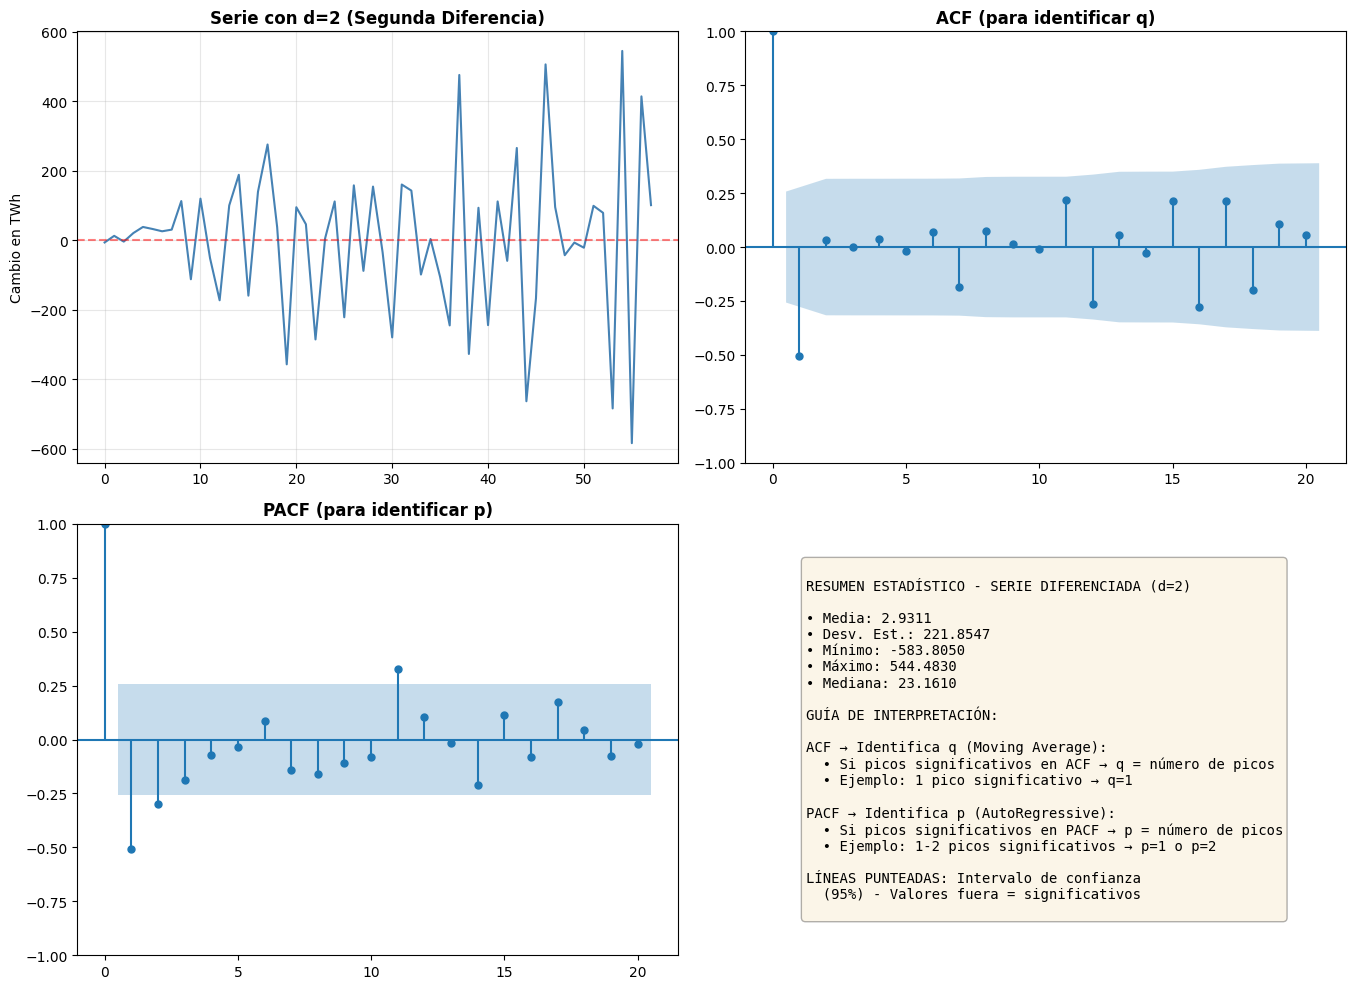


ANÁLISIS DETALLADO DE ACF Y PACF

VALORES DE ACF (primeros 10 lags):
──────────────────────────────────────────────────
  Lag 0: 1.000000
  Lag 1: -0.505589
  Lag 2: 0.033949
  Lag 3: -0.000315
  Lag 4: 0.035529
  Lag 5: -0.020143
  Lag 6: 0.069535
  Lag 7: -0.184095
  Lag 8: 0.072274
  Lag 9: 0.016185

VALORES DE PACF (primeros 10 lags):
──────────────────────────────────────────────────
  Lag 0: 1.000000
  Lag 1: -0.514459
  Lag 2: -0.312114
  Lag 3: -0.206671
  Lag 4: -0.082677
  Lag 5: -0.041917
  Lag 6: 0.098831
  Lag 7: -0.163431
  Lag 8: -0.195422
  Lag 9: -0.146373

Umbral de significancia (95%): ±0.2574

──────────────────────────────────────────────────
Picos significativos en ACF (lags 1-9): 1
Picos significativos en PACF (lags 1-9): 2
──────────────────────────────────────────────────


In [23]:
print("=" * 70)
print("IDENTIFICACIÓN DE PARÁMETROS p Y q PARA ARIMAX")
print("=" * 70)

# ============================================================================
# 2. APLICAR DIFERENCIACIÓN d=2
# ============================================================================
print("\n→ Aplicando diferenciación d=2 a la serie original...")
serie_diferenciada_2 = np.diff(serie_nuclear, n=2)

print(f"  Longitud serie original: {len(serie_nuclear)}")
print(f"  Longitud serie d=2: {len(serie_diferenciada_2)}")

# ============================================================================
# 3. GRAFICAR ACF Y PACF
# ============================================================================
# ACF te ayuda a identificar q (Moving Average)
# PACF te ayuda a identificar p (AutoRegressive)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Serie diferenciada d=2
axes[0, 0].plot(serie_diferenciada_2, linewidth=1.5, color='steelblue')
axes[0, 0].set_title('Serie con d=2 (Segunda Diferencia)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cambio en TWh')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Gráfico 2: ACF (AutoCorrelation Function)
plot_acf(serie_diferenciada_2, lags=20, ax=axes[0, 1], title='ACF - Consumo Nuclear d=2')
axes[0, 1].set_title('ACF (para identificar q)', fontsize=12, fontweight='bold')

# Gráfico 3: PACF (Partial AutoCorrelation Function)
plot_pacf(serie_diferenciada_2, lags=20, ax=axes[1, 0], title='PACF - Consumo Nuclear d=2')
axes[1, 0].set_title('PACF (para identificar p)', fontsize=12, fontweight='bold')

# Gráfico 4: Análisis de datos resumen
axes[1, 1].axis('off')
info_text = f"""
RESUMEN ESTADÍSTICO - SERIE DIFERENCIADA (d=2)

• Media: {serie_diferenciada_2.mean():.4f}
• Desv. Est.: {serie_diferenciada_2.std():.4f}
• Mínimo: {serie_diferenciada_2.min():.4f}
• Máximo: {serie_diferenciada_2.max():.4f}
• Mediana: {np.median(serie_diferenciada_2):.4f}

GUÍA DE INTERPRETACIÓN:

ACF → Identifica q (Moving Average):
  • Si picos significativos en ACF → q = número de picos
  • Ejemplo: 1 pico significativo → q=1

PACF → Identifica p (AutoRegressive):
  • Si picos significativos en PACF → p = número de picos
  • Ejemplo: 1-2 picos significativos → p=1 o p=2

LÍNEAS PUNTEADAS: Intervalo de confianza
  (95%) - Valores fuera = significativos
"""
axes[1, 1].text(0.1, 0.5, info_text, fontsize=10, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('acf_pacf_analisis.png', dpi=300, bbox_inches='tight')
print("\n✅ Gráfico guardado como 'acf_pacf_analisis.png'")
plt.show()

# ============================================================================
# 4. ANÁLISIS AUTOMÁTICO DE ACF Y PACF
# ============================================================================
print("\n" + "=" * 70)
print("ANÁLISIS DETALLADO DE ACF Y PACF")
print("=" * 70)



# Calcular ACF y PACF
acf_values = acf(serie_diferenciada_2, nlags=20)
pacf_values = pacf(serie_diferenciada_2, nlags=20)

print("\nVALORES DE ACF (primeros 10 lags):")
print("─" * 50)
for i, val in enumerate(acf_values[:10]):
    print(f"  Lag {i}: {val:.6f}")

print("\nVALORES DE PACF (primeros 10 lags):")
print("─" * 50)
for i, val in enumerate(pacf_values[:10]):
    print(f"  Lag {i}: {val:.6f}")

# Umbral de significancia (95% de confianza)
umbral = 1.96 / np.sqrt(len(serie_diferenciada_2))

print(f"\nUmbral de significancia (95%): ±{umbral:.4f}")

# Contar picos significativos
picos_acf = sum([1 for i in range(1, 10) if abs(acf_values[i]) > umbral])
picos_pacf = sum([1 for i in range(1, 10) if abs(pacf_values[i]) > umbral])

print(f"\n{'─' * 50}")
print(f"Picos significativos en ACF (lags 1-9): {picos_acf}")
print(f"Picos significativos en PACF (lags 1-9): {picos_pacf}")
print(f"{'─' * 50}")


In [24]:
serie_gdp_diff2 = np.diff(np.diff(df_nuclear_consumo['gdp']))
serie_gdp_diff2 = serie_gdp_diff2[~np.isnan(serie_gdp_diff2)]
# Alternativamente, si sospechas inf, también puedes usar np.isfinite:
# serie_gdp_diff2 = serie_gdp_diff2[np.isfinite(serie_gdp_diff2)]

result_gdp_d2 = adfuller(serie_gdp_diff2)
print(f"p-value GDP diferenciada (d=2): {result_gdp_d2[1]:.6f}")


p-value GDP diferenciada (d=2): 0.000000


Nivel: p=0.2923
Δ: p=0.2387
Δ²: p=0.0000
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -382.768
Date:                Thu, 06 Nov 2025   AIC                            773.537
Time:                        17:36:55   BIC                            781.778
Sample:                             0   HQIC                           776.747
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1847      0.295     -0.627      0.531      -0.762       0.393
ar.L2         -0.0819      0.213     -0.384      0.701      -0.499       0.336
ma.L1      

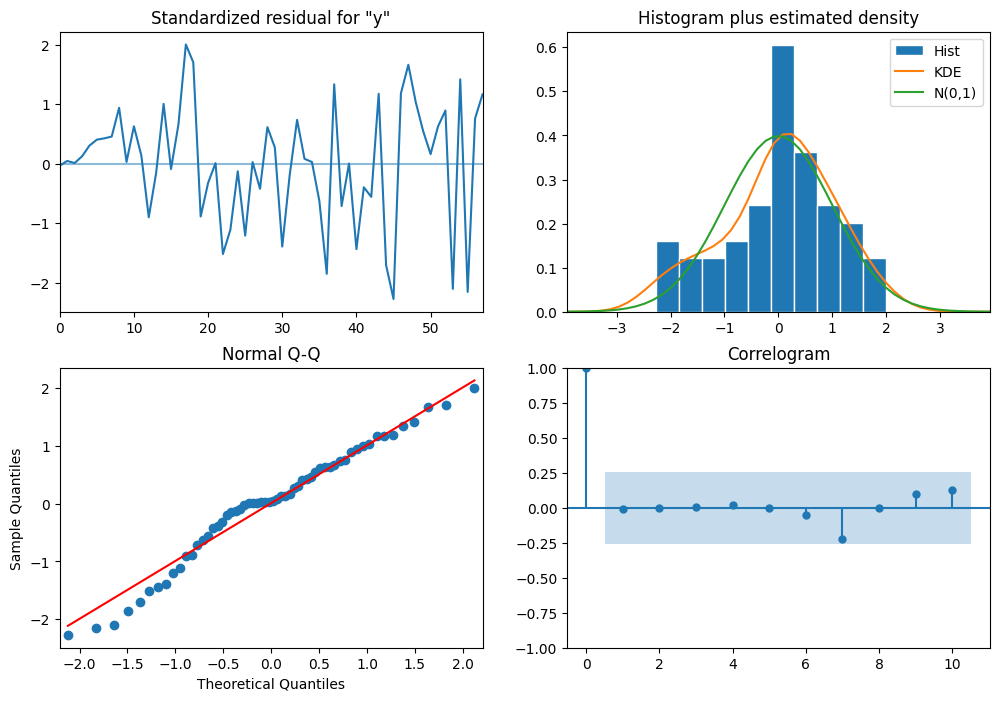

Ljung-Box (p-values):
     lb_stat  lb_pvalue
10  5.749926   0.835818
Jarque-Bera p=0.3512
2025: 6897.1 TWh (IC95% [6550.6, 7243.7])
2026: 6945.5 TWh (IC95% [6391.3, 7499.6])
2027: 7003.4 TWh (IC95% [6231.1, 7775.8])
2028: 7057.7 TWh (IC95% [6040.9, 8074.5])
2029: 7111.9 TWh (IC95% [5830.6, 8393.2])


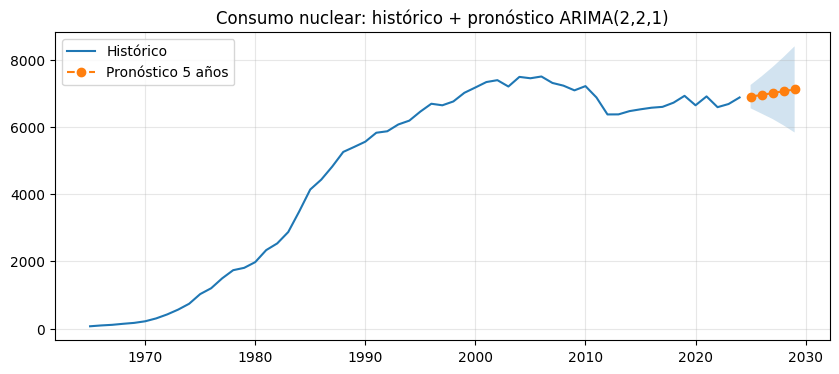

In [27]:
# Entrena ARIMA sobre todos los datos históricos y haz pronóstico para los siguientes 5 años

# 1) Prepara la serie
world = df_nuclear_consumo[df_nuclear_consumo['country']=='World'].sort_values('year')[['year','nuclear_consumption']].reset_index(drop=True)
y = world['nuclear_consumption'].astype(float).ffill().bfill().values
years = world['year'].values

# 2) Estacionariedad
# (mantén el test, pero para entrenar usa toda la serie)
def adf(x, name):
    r = adfuller(pd.Series(x).dropna(), autolag='AIC')
    print(f'{name}: p={r[1]:.4f}')
adf(y, 'Nivel')
adf(np.diff(y), 'Δ')
adf(np.diff(np.diff(y)), 'Δ²')  # esperamos p<0.05 ⇒ d=2

# 3) Entrenamiento ARIMA
model = ARIMA(y, order=(2,2,1)).fit()
print(model.summary())

# 4) Diagnósticos
fig = model.plot_diagnostics(figsize=(12,8)); plt.show()
resid = model.resid
print('Ljung-Box (p-values):')
print(acorr_ljungbox(resid, lags=[10], return_df=True))
jb_stat, jb_p = jarque_bera(resid); print(f'Jarque-Bera p={jb_p:.4f}')

# 5) Pronóstico 5 años
fc5 = model.get_forecast(steps=5)
pred5 = fc5.predicted_mean
ci5 = fc5.conf_int()
future_years = np.arange(years[-1]+1, years[-1]+6)  # <-- Añade esto

for yr, p, (lo, hi) in zip(future_years, pred5, ci5):
    print(f'{yr}: {p:.1f} TWh (IC95% [{lo:.1f}, {hi:.1f}])')

plt.figure(figsize=(10,4))
plt.plot(years, y, label='Histórico')
plt.plot(future_years, pred5, 'o--', label='Pronóstico 5 años')
plt.fill_between(future_years, ci5[:,0], ci5[:,1], alpha=0.2)
plt.title('Consumo nuclear: histórico + pronóstico ARIMA(2,2,1)')
plt.legend(); plt.grid(alpha=0.3); plt.show()



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a function to perform cross-validation
def perform_cross_validation(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-validation RMSE scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}")
    print(f"Standard deviation of RMSE: {rmse_scores.std()}")

# Example usage (replace `model`, `X`, and `y` with actual variables)
# perform_cross_validation(model, X, y)